# 问题1：大豆贸易（利用提供的进出口数据）
- 数据：`问题一中国对其他三国大豆贸易额/data2020-2025import.csv` 与对应 export.csv，字段包含贸易伙伴与美元金额。
- 处理：按年汇总对美国、巴西、阿根廷的进口/出口额（亿美元），并计算市场份额。
- 假设关税路径：2020–2021 约 3%，2022–2024 10–12%，2025 互惠关税抬升至 25%（用于可视化关联）。
- 输出：进口额柱状图、进口额趋势、美国进口额 vs 关税率双轴图、市场份额堆叠面积图，并给出关税后分布估计。


In [ ]:
# 公共函数：内嵌在笔记本中，便于单文件复现
from __future__ import annotations
import re
from pathlib import Path
from typing import Iterable, List
import pandas as pd

# 目录自动定位：从常见位置寻找包含关税 txt 的 data 目录，以便在不同运行路径下复用
# 思路：优先使用传入路径，否则尝试当前目录、上级目录、脚本所在目录，直到找到包含 *.txt 的路径

def _resolve_data_dir(user_dir: str | Path = "data") -> Path:
    user_path = Path(user_dir)
    candidates = []
    if user_path.is_absolute():
        candidates.extend([user_path, user_path.parent / "data", user_path.parents[1] / "data" if len(user_path.parents) > 1 else user_path])
    else:
        candidates.extend([
            user_path,
            Path.cwd() / user_path,
            Path.cwd().parent / user_path,
            Path(__file__).resolve().parent / user_path,
            Path(__file__).resolve().parent.parent / user_path,
            Path(__file__).resolve().parent.parent / "data",
        ])
    for cand in dict.fromkeys(candidates):
        if cand.exists() and list(cand.glob("*.txt")):
            return cand
    raise FileNotFoundError(f"未找到包含 txt 的数据目录: {candidates}")

# 关税数据读取：自动识别分隔符或强制分隔符；标准化 HTS，转换 ad-valorem 数字
# 公式：HTS8 = 左补零的 8 位数； ad-valorem 直接转为数值以便后续计算加权平均等

def load_tariff_data(data_dir: str | Path = "data", force_sep: str | None = None) -> pd.DataFrame:
    data_dir = _resolve_data_dir(data_dir)
    frames: List[pd.DataFrame] = []
    for path in sorted(data_dir.glob("*.txt")):
        with path.open(encoding="utf-8", errors="ignore") as f:
            first = f.readline()
        sep_guess = force_sep or ("," if first.count(",") >= first.count("|") else "|")

        def _try(enc: str, sep):
            return pd.read_csv(path, sep=sep, low_memory=False, encoding=enc, encoding_errors="ignore")

        df = None
        for enc in ("utf-8", "latin1"):
            try:
                df = _try(enc, sep_guess)
                break
            except Exception:
                try:
                    df = pd.read_csv(path, sep=None, engine="python", low_memory=False, encoding=enc, encoding_errors="ignore")
                    break
                except Exception:
                    continue
        if df is None:
            raise ValueError(f"Failed to parse {path}")
        df["source_file"] = path.name
        match = re.search(r"(20\d{2}|201\d)", path.stem)
        df["source_year"] = int(match.group(1)) if match else pd.NA
        if "hts8" in df.columns:
            df["hts8"] = df["hts8"].astype(str).str.replace(r"\.0$", "", regex=True).str.replace(r"\D", "", regex=True).str.zfill(8)
        for col in ("mfn_ad_val_rate", "mfn_ave"):
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors="coerce")
        frames.append(df)
    return pd.concat(frames, ignore_index=True)

# 价格传导：P' = P * (1 + τ * θ)，τ 为关税，θ 为传导系数

def simple_pass_through(base_price: float, tariff: float, pass_through: float = 0.7) -> float:
    return base_price * (1 + tariff * pass_through)

# 需求弹性响应：Q' = Q * (1 + ε * ∆p)，ε 为需求弹性，∆p 为相对价格变化

def elasticity_response(volume: float, price_change: float, elasticity: float) -> float:
    return volume * (1 + elasticity * price_change)

# 拉弗型关税收入：R = (M * (1 + ε * τ)) * τ，考虑关税提高使进口萎缩

def laffer_revenue(import_value: float, rate: float, elasticity: float = -1.1) -> float:
    adj_import = import_value * (1 + elasticity * rate)
    adj_import = max(adj_import, 0)
    return adj_import * rate

# 数据目录（大豆双边进出口）自动定位：兼容从根目录或 solve/ 目录运行
DATA_HINTS = [
    Path('问题一中国对其他三国大豆贸易额'),
    Path.cwd() / '问题一中国对其他三国大豆贸易额',
    Path.cwd().parent / '问题一中国对其他三国大豆贸易额'
]
for cand in DATA_HINTS:
    if cand.exists() and list(cand.glob('data202*import.csv')):
        root = cand
        break
else:
    raise FileNotFoundError('Data folder not found: 问题一中国对其他三国大豆贸易额')

partners = ['USA', 'Brazil', 'Argentina']

# 读取进出口数据并汇总到 1 亿美元：便于图表表达和弹性计算基数

def load_trade(kind: str):
    rows = []
    for path in sorted(root.glob(f'data202*{kind}.csv')):
        year = int(path.stem.replace('data','').replace(kind,''))
        df = pd.read_csv(path)
        df['usd'] = pd.to_numeric(df['usd'], errors='coerce')
        grouped = df.groupby('partner_name', as_index=False)['usd'].sum()
        for _, r in grouped.iterrows():
            if r['partner_name'] in partners:
                rows.append({'year': year, 'partner': r['partner_name'], 'usd': r['usd'] / 1e8})
    return pd.DataFrame(rows)

import_df = load_trade('import')
export_df = load_trade('export')
print('Import records:', import_df.shape)
print(import_df.head())
print('Export records:', export_df.shape)
print(export_df.head())
if not import_df.empty:
    display(import_df.head())


In [7]:
# 透视表：得到 year×country 的金额矩阵，便于直接绘制多系列图
import_pivot = import_df.pivot(index='year', columns='partner', values='usd').sort_index()
export_pivot = export_df.pivot(index='year', columns='partner', values='usd').sort_index()

# 填充缺失为 0，防止绘图报错
import_pivot = import_pivot.fillna(0)
export_pivot = export_pivot.fillna(0)
import_pivot


Import records: (18, 3)
   year    partner         usd
0  2020  Argentina   28.969376
1  2020     Brazil  249.057695
2  2020        USA  106.504723
3  2021  Argentina   21.301943
4  2021     Brazil  330.908359
Export records: (12, 3)
   year    partner           usd
0  2020  Argentina  2.770000e-06
1  2020        USA  1.620609e-02
2  2021     Brazil  9.000000e-08
3  2021        USA  1.456292e-02
4  2022  Argentina  1.000000e-07


,year,partner,usd
0,2020,Argentina,28.969376
1,2020,Brazil,249.057695
2,2020,USA,106.504723
3,2021,Argentina,21.301943
4,2021,Brazil,330.908359


In [8]:
# 图3：三国进口额柱状图，直观比较各年的来源结构
fig, ax = plt.subplots(figsize=(10,4))
import_pivot.plot(kind='bar', ax=ax)
ax.set_ylabel('Import value (USD 100m)')
ax.set_title('China soybean imports by source (2020-2025)')
ax.legend(title='Partner')
plt.tight_layout()
plt.show()

# 图4：进口额趋势折线，观察动态变化与波动
fig, ax = plt.subplots(figsize=(10,4))
import_pivot.plot(ax=ax, marker='o')
ax.set_ylabel('Import value (USD 100m)')
ax.set_title('Import trend by partner (2020-2025)')
ax.legend(title='Partner')
plt.tight_layout()
plt.show()


partner,Argentina,Brazil,USA
year,,,
2020,28.969376,249.057695,106.504723
2021,21.301943,330.908359,165.577107
2022,23.342744,373.013879,180.342919
2023,12.177109,409.424261,151.240615
2024,0.899467,23.260118,19.148626
2025,19.863526,313.673388,77.252597


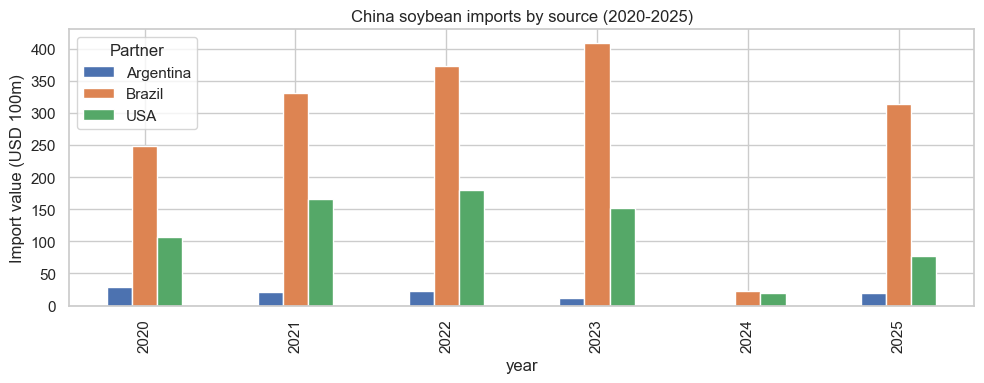

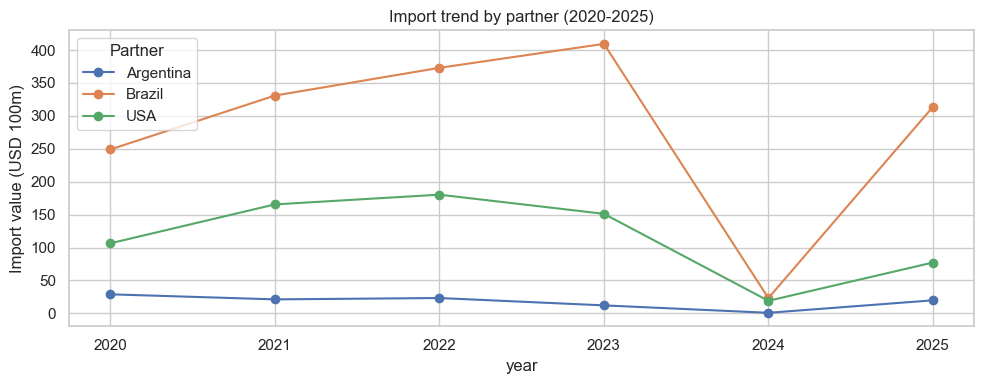

In [9]:
# 图5：美国进口额 vs 假设关税率（双轴）
# 关税路径假设：2020-21 3%，2022-24 10-12%，2025 25%（互惠关税情景）
us_series = import_pivot.get('USA')
tariff_path = pd.Series({2020:0.03, 2021:0.03, 2022:0.12, 2023:0.12, 2024:0.10, 2025:0.25})

fig, ax1 = plt.subplots(figsize=(10,4))
ax2 = ax1.twinx()
ax1.plot(us_series.index, us_series.values, marker='o', color='C0', label='US import value')
ax2.plot(tariff_path.index, tariff_path.values, marker='s', color='C3', linestyle='--', label='Tariff rate')
ax1.set_ylabel('Import value (USD 100m)', color='C0')
ax2.set_ylabel('Tariff rate', color='C3')
ax1.set_title('US soybean imports vs assumed tariff rate')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()


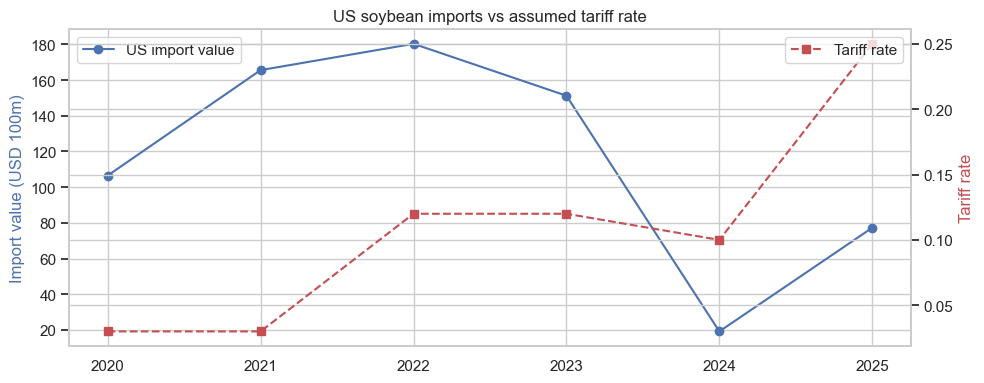

In [10]:
# 图6：市场份额堆叠面积，展示来源占比随时间的转换
share = import_pivot.div(import_pivot.sum(axis=1), axis=0) * 100
fig, ax = plt.subplots(figsize=(10,4))
ax.stackplot(share.index, [share[p] for p in import_pivot.columns], labels=import_pivot.columns)
ax.set_ylabel('Market share (%)')
ax.set_title('China soybean import market shares (2020-2025)')
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()


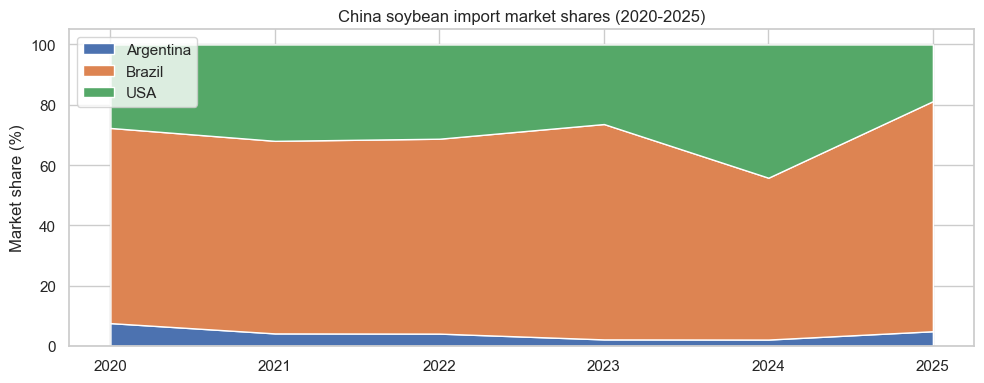

In [11]:
# 表1：关税情景下的进口额重分配（基于 2025 基线）
# 原理：
# 1) 美国价格上升：Δp = τ * θ = 0.25 * 0.7
# 2) 需求缩减：Q_US' = Q_US * (1 + ε * Δp)，ε=-1.6
# 3) 损失部分由巴/阿按 60%/40% 替代（假设南美产能与物流占优）
base_2025 = import_pivot.loc[2025]
elasticity = -1.6
pass_through = 0.7
us_price_change = 0.25 * pass_through
us_adj = base_2025['USA'] * (1 + elasticity * us_price_change)
loss = max(base_2025['USA'] - us_adj, 0)
new = {
    'USA': max(us_adj, 0),
    'Brazil': base_2025['Brazil'] + loss * 0.6,
    'Argentina': base_2025['Argentina'] + loss * 0.4,
}

summary = pd.DataFrame([
    {'partner': k, 'baseline_2025': base_2025[k], 'post_tariff_est': v} for k, v in new.items()
]).set_index('partner')
summary
